In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import math
from scipy import stats
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
Data=pd.read_csv('Data.csv',sep=';')

In [3]:
Data

,DEBTOR_NO,RAND_NO,SNAPSHOT_DATE,IS_PAID_12M,IS_PAID_6M,IS_PAID_3M,IS_PAID_AMT_12M,IS_PAID_AMT_6M,IS_PAID_AMT_3M,CASE_AGE_MONTHS,INTEREST_RATE,REM_PRINCIPAL_AMT,REM_PRINCIPAL_INTEREST_AMT,REM_TOTAL_AMT,DEBTOR_AGE,PAID_AMT_12M,PAID_AMT_6M,PAID_AMT_3M,INCOME_TOTAL_LAST_YEAR,TOTAL_DEBT_AMT
0,1,53390578,2019-12-31,0,0,0,0,0,0,98,27,3000.0,10000,11000,45,0,0,0,0.0,67233
1,2,72536782,2019-12-31,0,0,0,0,0,0,96,26,18000.0,47000,47000,28,0,0,0,54004.0,152604
2,3,6806414,2019-12-31,0,0,0,0,0,0,92,9,3000.0,6000,6000,22,0,0,0,113829.0,42052
3,4,6277796,2019-12-31,0,0,0,0,0,0,98,26,9000.0,23000,24000,22,0,0,0,191168.0,62821
4,5,69339423,2019-12-31,0,0,0,0,0,0,98,26,1000.0,4000,5000,54,0,0,0,185517.0,45237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16141,16142,77324789,2019-12-31,0,0,0,0,0,0,4,26,1000.0,1000,2000,19,0,0,0,NaN,0
16142,16143,18997081,2019-12-31,0,0,0,0,0,0,4,25,0.0,0,0,65,0,0,0,NaN,82045
16143,16144,99944263,2019-12-31,1,0,0,378,0,0,4,26,0.0,0,0,24,0,0,0,NaN,13462
16144,16145,24251613,2019-12-31,1,1,0,12752,884,0,4,23,20000.0,21000,22000,39,0,0,0,NaN,37923


# Data Cleaning

In [4]:
# We have three columns which are our main targets IS_PAID_3M, IS_PAID_6M, IS_PAID_12M. We are intrested in knowing
# the likelihood of payment, so the next three columns IS_PAID_AMT_3M, IS_PAID_AMT_6M,IS_PAID_AMT_12M are not our intrest
# and do not help the likelihood.
# We have option of looking at the problem as binary-class task (is paid or not paid in 3 month, or 6, 12 months), or 
# multi-class problem (all three target columns). I choose the first one, becasue the binary class is easeir to learn
# and faster. However, I also tried multi-class and came to conclution that binary class is better.
# I investigate if the person pays in 3 months or not. Then one can reapeat the same code for 6 months and 12 months.

Data['Likelihood']=Data['IS_PAID_3M']

In [5]:
# The number of cases where the payment in 3 months occured or not occured. It tells us we have very imbalanced data.

Data['Likelihood'].value_counts()

0    15241
1      905
Name: Likelihood, dtype: int64

In [6]:
# 1- There are columns which have no influence on the learning, like random numbers,snapshot dates, deptor number.
# 2- There are columns which should not be consired as features,as they are in target side.
# 3- There are columns which are highly correlated, so I remove 'REM_PRINCIPAL_INTEREST_AMT','REM_PRINCIPAL_AMT'.
# I had showed their high correlations to 'TOTAL_DEBT_AMT' in  the exploring code.
# However, I have also solved the case with keeping them, but no improvement.

columns=['RAND_NO','IS_PAID_3M','IS_PAID_6M','IS_PAID_12M','IS_PAID_AMT_3M','IS_PAID_AMT_6M','IS_PAID_AMT_12M',
         'REM_PRINCIPAL_INTEREST_AMT','REM_PRINCIPAL_AMT',
         'SNAPSHOT_DATE','DEBTOR_NO']
Data=Data.drop(columns,axis=1)

In [7]:
# How many null values do we have. It is about 20 percent of data.

Data.isnull().sum()

CASE_AGE_MONTHS              0
INTEREST_RATE                0
REM_TOTAL_AMT                0
DEBTOR_AGE                   0
PAID_AMT_12M                 0
PAID_AMT_6M                  0
PAID_AMT_3M                  0
INCOME_TOTAL_LAST_YEAR    3810
TOTAL_DEBT_AMT               0
Likelihood                   0
dtype: int64

In [8]:
# Very important step: generally there are several options to deal with null values. Droping them by row, droping whole
# column, replacing them by meadian (here we have non-gaussian data), etc. I have tried several approachs to be able to
# keep them but came to coclusion to drop them as non of others helped the case.

Cleaned_Data=Data.dropna(axis=0)
Cleaned_Data

,CASE_AGE_MONTHS,INTEREST_RATE,REM_TOTAL_AMT,DEBTOR_AGE,PAID_AMT_12M,PAID_AMT_6M,PAID_AMT_3M,INCOME_TOTAL_LAST_YEAR,TOTAL_DEBT_AMT,Likelihood
0,98,27,11000,45,0,0,0,0.0,67233,0
1,96,26,47000,28,0,0,0,54004.0,152604,0
2,92,9,6000,22,0,0,0,113829.0,42052,0
3,98,26,24000,22,0,0,0,191168.0,62821,0
4,98,26,5000,54,0,0,0,185517.0,45237,0
...,...,...,...,...,...,...,...,...,...,...
15428,7,27,0,31,0,0,0,94304.0,27033,0
15429,6,25,0,43,0,0,0,0.0,27333,0
15432,7,24,0,46,0,0,0,119258.0,91208,0
15433,7,24,0,24,0,0,0,59428.0,8882,0


<AxesSubplot:>

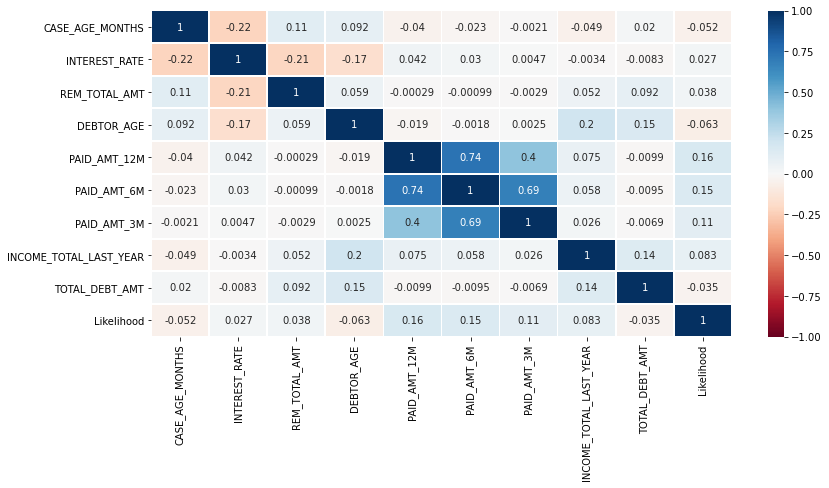

In [9]:
# correlation between columns

plt.figure(figsize=(13,6))
sns.heatmap(Cleaned_Data.corr(),cmap= 'RdBu', linewidths=0.9,annot=True,vmin=-1,vmax=1)

# Features and target

In [10]:
#separating features and target 

X=Cleaned_Data.drop('Likelihood',axis=1)

In [11]:
y=Cleaned_Data['Likelihood']

# Normalization

In [12]:
# Normalizing data. I normalize because we have data in very diffetnet ranges.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scal= scaler.fit_transform(X)
X=pd.DataFrame(X_scal,columns=X.columns)
X.head(3)

,CASE_AGE_MONTHS,INTEREST_RATE,REM_TOTAL_AMT,DEBTOR_AGE,PAID_AMT_12M,PAID_AMT_6M,PAID_AMT_3M,INCOME_TOTAL_LAST_YEAR,TOTAL_DEBT_AMT
0,1.000000,0.54,0.051402,0.346667,0.0,0.0,0.0,0.000000,0.002276
1,0.979798,0.52,0.219626,0.120000,0.0,0.0,0.0,0.032780,0.005166
2,0.939394,0.18,0.028037,0.040000,0.0,0.0,0.0,0.069094,0.001423


# Oversample

In [13]:
# One other important step for this task is how to deal with imbalance data. There are some approchs to make the 
#data balaced. Like oversampling or undersampling. I have tried both and prefered to go with oversampling, due to
# accuracy outcome.

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
sm = SMOTE(sampling_strategy='minority',k_neighbors=5)

In [14]:
X, y =sm.fit_resample(X, y)

In [15]:
Data_sm=pd.concat([X,y],axis=1)

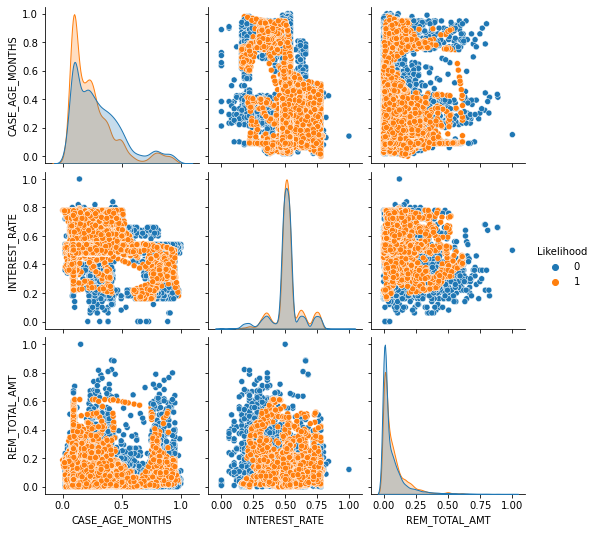

In [16]:
# Now data looks balaced:

sns.pairplot(pd.concat([X.iloc[:,:3],y],axis=1), hue='Likelihood')

# Train test split

In [17]:
# So finally I start ML. I devide the data into test, train:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
y_train.value_counts()

1    8773
0    8694
Name: Likelihood, dtype: int64

# Below I try several algorithms to see which one provide better accuracy.

# Logistic Regression

In [19]:
# First algorithm is logistic regression.

logmodel=LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

In [20]:
lg_prediction=logmodel.predict(X_test)

In [21]:
# The confiucation matrix and accuracy below indicated the logistic regression does not predict well.

print(confusion_matrix(y_test,lg_prediction))
print(classification_report(y_test,lg_prediction))

[[1973  978]
 [ 949 1923]]
              precision    recall  f1-score   support

           0       0.68      0.67      0.67      2951
           1       0.66      0.67      0.67      2872

    accuracy                           0.67      5823
   macro avg       0.67      0.67      0.67      5823
weighted avg       0.67      0.67      0.67      5823



# K nearest neighber

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
knn= KNeighborsClassifier(n_neighbors=1)

In [24]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [25]:
knn_prediction=knn.predict(X_test)

In [26]:
print(confusion_matrix(y_test,knn_prediction))

[[2475  476]
 [  49 2823]]


In [27]:
print(classification_report(y_test,knn_prediction))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      2951
           1       0.86      0.98      0.91      2872

    accuracy                           0.91      5823
   macro avg       0.92      0.91      0.91      5823
weighted avg       0.92      0.91      0.91      5823



#### Elbow method

In [28]:
# Elbow method is for finding best number of neighbures which provide best accuracy

error_rate=[]
for i in range (1,30):
    knn= KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    knn_prediction_i=knn.predict(X_test)
    error_rate.append(np.mean(knn_prediction_i != y_test))

Text(0, 0.5, 'error_rate')

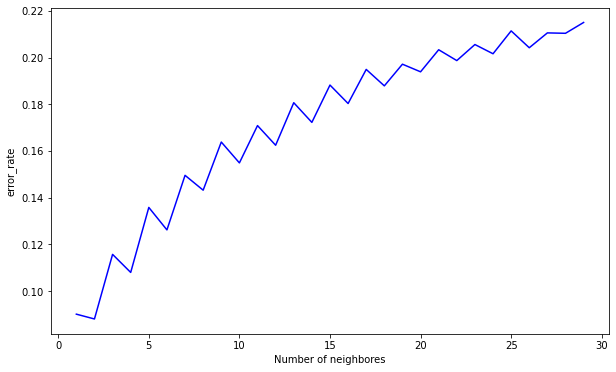

In [29]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30), error_rate, color='blue')
plt.xlabel('Number of neighbores')
plt.ylabel('error_rate')

In [30]:
# From last plot we choose number of neighbors two:

knn= KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train,y_train)
knn_prediction=knn.predict(X_test)

print(confusion_matrix(y_test,knn_prediction))
print(classification_report(y_test,knn_prediction))

[[2575  376]
 [ 137 2735]]
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      2951
           1       0.88      0.95      0.91      2872

    accuracy                           0.91      5823
   macro avg       0.91      0.91      0.91      5823
weighted avg       0.91      0.91      0.91      5823



## Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
y_train.value_counts()

1    8773
0    8694
Name: Likelihood, dtype: int64

In [33]:
# I have played with the max_depth and n_estimators and came to best ones as:

rf_model = RandomForestClassifier(max_depth=20, n_estimators=500,random_state=0)

In [34]:
rf_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, n_estimators=500, random_state=0)

In [35]:
rf_prediction=rf_model.predict(X_test)

In [36]:
X.columns[np.argsort(rf_model.feature_importances_)[::-1]]

Index(['REM_TOTAL_AMT', 'PAID_AMT_12M', 'INCOME_TOTAL_LAST_YEAR',
       'CASE_AGE_MONTHS', 'INTEREST_RATE', 'DEBTOR_AGE', 'TOTAL_DEBT_AMT',
       'PAID_AMT_6M', 'PAID_AMT_3M'],
      dtype='object')

In [37]:
# It seems Random Forest does pretty good jobs, as expected.

print(confusion_matrix(y_test,rf_prediction))
print('\n')
print(classification_report(y_test,rf_prediction))

[[2798  153]
 [ 104 2768]]


              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2951
           1       0.95      0.96      0.96      2872

    accuracy                           0.96      5823
   macro avg       0.96      0.96      0.96      5823
weighted avg       0.96      0.96      0.96      5823



In [38]:
# Here I test an example data to see what is the prediction of Random forest

example_test=X_test[:10]

In [39]:
example_result=rf_model.predict(example_test)
example_result

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 1], dtype=int64)

In [40]:
# y_test in the data is compared to latter

y_test[:10].values

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 1], dtype=int64)

# SVM

In [41]:
from sklearn.svm import SVC

In [42]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_svm=Cleaned_Data.drop('Likelihood',axis=1)

y_svm=Cleaned_Data['Likelihood']
scaler.fit(X_svm)
scaled_features= scaler.transform(X_svm)

In [43]:
X_stand_svm=pd.DataFrame(scaled_features,columns=X_svm.columns)

In [44]:
X_stand_svm.head(3)

,CASE_AGE_MONTHS,INTEREST_RATE,REM_TOTAL_AMT,DEBTOR_AGE,PAID_AMT_12M,PAID_AMT_6M,PAID_AMT_3M,INCOME_TOTAL_LAST_YEAR,TOTAL_DEBT_AMT
0,3.270108,0.293010,-0.107984,0.414920,-0.121004,-0.088504,-0.045801,-1.056513,-0.206926
1,3.175265,0.108762,1.589730,-0.824961,-0.121004,-0.088504,-0.045801,-0.641535,-0.009364
2,2.985581,-3.023450,-0.343778,-1.262566,-0.121004,-0.088504,-0.045801,-0.181826,-0.265199


In [45]:
# For SVM one should try to do standardization, becasue it works on separation vector and the scale of data matters.

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
svm_sm = SMOTE(sampling_strategy='minority',k_neighbors=5)

X_stand_svm, y_svm =svm_sm.fit_resample(X_stand_svm, y_svm)

In [46]:
X_svm.shape

(12336, 9)

In [47]:
# Train test split for standardizaed data

X_train_stand, X_test_stand, y_train, y_test= train_test_split(X_stand_svm, y, test_size=0.25, random_state=42)

In [48]:
svm_model=SVC(gamma=1,C=1)

In [49]:
y_train.value_counts()

1    8773
0    8694
Name: Likelihood, dtype: int64

In [50]:
svm_model.fit(X_train_stand,y_train)

SVC(C=1, gamma=1)

In [51]:
prediction=svm_model.predict(X_test_stand)

In [52]:
print(confusion_matrix(y_test,prediction))
print('\n')
print(classification_report(y_test,prediction))

[[2422  529]
 [ 348 2524]]


              precision    recall  f1-score   support

           0       0.87      0.82      0.85      2951
           1       0.83      0.88      0.85      2872

    accuracy                           0.85      5823
   macro avg       0.85      0.85      0.85      5823
weighted avg       0.85      0.85      0.85      5823



In [53]:
# Here I test an example data to see what is the prediction of SVM

example_test_svm=X_test_stand[:10]

In [54]:
example_result_svm=svm_model.predict(example_test_svm)
example_result_svm

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1], dtype=int64)

In [55]:
# y_test in the data is compared to latter

y_test[:10].values

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 1], dtype=int64)

#### Best values of C and gamma by grid serach

In [56]:
# Here I find best values of gamma and c to get highest accoracy for svm. I have tried this step and got the values 
# and inseted the in the model above. I do not reapet it here again as it is time consuming.

from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.model_selection import LeaveOneOut

In [57]:
# grid_parameter={'C':[0.1,1,10],'gamma':[10,1,0.1]}
# grid=GridSearchCV(SVC(),grid_parameter,verbose=3)
# grid.fit(X_train,y_train)
# grid.best_params_
# grid.best_estimator_
# grid_prediction=grid.predict(X_test)

In [58]:
# print(confusion_matrix(y_test,grid_prediction))
# print('\n')
# print(classification_report(y_test,grid_prediction))

# K-means clustering

In [59]:
# Of course K-means is for unsupervised learning, but we still can try to see for labled data.

from sklearn.cluster import KMeans

In [60]:
km_model=KMeans(n_clusters=2)

In [61]:
km_model.fit(X_train,y_train)

KMeans(n_clusters=2)

In [62]:
km_prediction=km_model.predict(X_test)

In [63]:
print(confusion_matrix(y_test,km_prediction))
print('\n')
print(classification_report(y_test,km_prediction))

[[2127  824]
 [2399  473]]


              precision    recall  f1-score   support

           0       0.47      0.72      0.57      2951
           1       0.36      0.16      0.23      2872

    accuracy                           0.45      5823
   macro avg       0.42      0.44      0.40      5823
weighted avg       0.42      0.45      0.40      5823



# Naive Bayes

In [64]:
from sklearn.naive_bayes import GaussianNB

In [65]:
nb_model=GaussianNB()

In [66]:
nb_model.fit(X_train,y_train)

GaussianNB()

In [67]:
nb_prediction=nb_model.predict(X_test)

In [68]:
print(confusion_matrix(y_test,nb_prediction))
print('\n')
print(classification_report(y_test,nb_prediction))

[[2918   33]
 [2545  327]]


              precision    recall  f1-score   support

           0       0.53      0.99      0.69      2951
           1       0.91      0.11      0.20      2872

    accuracy                           0.56      5823
   macro avg       0.72      0.55      0.45      5823
weighted avg       0.72      0.56      0.45      5823



# Neural Network

In [69]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam,SGD

In [70]:
X_train.shape

(17467, 9)

In [71]:
y_train.shape

(17467,)

In [72]:
# I have done many different networks, by playing with number of layers, nodes, activation functions, epoch, 
# batch size, etc. However this is the best one I could have found. I consider the last layer as 2 units,
# however, I have also tried one node in output layer. This one works better.

model = Sequential()

model.add(Dense(32,input_shape=[9],activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(4, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(units = 2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                320       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 6

In [73]:
opt=Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [74]:
history=model.fit(X_train, y_train, epochs=100, batch_size=64,validation_data=(X_test,y_test))

Epoch 1/100
273/273 [==============================] - 2s 2ms/step - loss: 0.7127 - accuracy: 0.5770 - val_loss: 0.6850 - val_accuracy: 0.5380
Epoch 2/100
273/273 [==============================] - 0s 2ms/step - loss: 0.6667 - accuracy: 0.5964 - val_loss: 0.6522 - val_accuracy: 0.6212
Epoch 3/100
273/273 [==============================] - 0s 1ms/step - loss: 0.6530 - accuracy: 0.6205 - val_loss: 0.6296 - val_accuracy: 0.6541
Epoch 4/100
273/273 [==============================] - 0s 2ms/step - loss: 0.6418 - accuracy: 0.6356 - val_loss: 0.6189 - val_accuracy: 0.6658
Epoch 5/100
273/273 [==============================] - 0s 2ms/step - loss: 0.6321 - accuracy: 0.6464 - val_loss: 0.6093 - val_accuracy: 0.6773
Epoch 6/100
273/273 [==============================] - 0s 2ms/step - loss: 0.6215 - accuracy: 0.6569 - val_loss: 0.6358 - val_accuracy: 0.6198
Epoch 7/100
273/273 [==============================] - 0s 2ms/step - loss: 0.6033 - accuracy: 0.6771 - val_loss: 0.5697 - val_accuracy: 0.7245

Epoch 58/100
273/273 [==============================] - 0s 2ms/step - loss: 0.5233 - accuracy: 0.7355 - val_loss: 0.4972 - val_accuracy: 0.7761
Epoch 59/100
273/273 [==============================] - 0s 2ms/step - loss: 0.5220 - accuracy: 0.7399 - val_loss: 0.4880 - val_accuracy: 0.7707
Epoch 60/100
273/273 [==============================] - 0s 2ms/step - loss: 0.5207 - accuracy: 0.7432 - val_loss: 0.4935 - val_accuracy: 0.7726
Epoch 61/100
273/273 [==============================] - 0s 1ms/step - loss: 0.5206 - accuracy: 0.7369 - val_loss: 0.4957 - val_accuracy: 0.7627
Epoch 62/100
273/273 [==============================] - 0s 2ms/step - loss: 0.5210 - accuracy: 0.7413 - val_loss: 0.5026 - val_accuracy: 0.7539
Epoch 63/100
273/273 [==============================] - 0s 1ms/step - loss: 0.5224 - accuracy: 0.7363 - val_loss: 0.5006 - val_accuracy: 0.7690
Epoch 64/100
273/273 [==============================] - 0s 1ms/step - loss: 0.5209 - accuracy: 0.7388 - val_loss: 0.4803 - val_accuracy:

In [75]:
history_dict=history.history

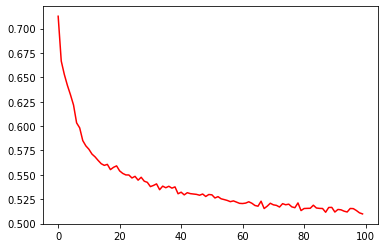

In [76]:
loss_values=history_dict['loss']
plt.figure
plt.plot(loss_values,'r')

In [77]:
nn_prediction=model.predict(X_test)

In [78]:
#  Prediction is the maximum probality:

nn_prediction=np.argmax(nn_prediction,axis=1)

In [79]:
print(confusion_matrix(y_test,nn_prediction))
print('\n')
print(classification_report(y_test,nn_prediction))

[[2161  790]
 [ 482 2390]]


              precision    recall  f1-score   support

           0       0.82      0.73      0.77      2951
           1       0.75      0.83      0.79      2872

    accuracy                           0.78      5823
   macro avg       0.78      0.78      0.78      5823
weighted avg       0.79      0.78      0.78      5823



In [80]:
# Here I test an example data to see what is the prediction of NN

example_test_nn=X_test[:10]

In [81]:
example_result_nn=model.predict(example_test_nn)
example_result_nn

array([[0.19528575, 0.80471426],
       [0.91005635, 0.08994369],
       [0.9250282 , 0.07497178],
       [0.8094602 , 0.19053976],
       [0.83799267, 0.16200735],
       [0.18748595, 0.81251407],
       [0.18748595, 0.81251407],
       [0.18748595, 0.81251407],
       [0.53293407, 0.46706593],
       [0.18748595, 0.81251407]], dtype=float32)

In [82]:
np.argmax(example_result_nn,1)

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 1], dtype=int64)

In [83]:
y_test[:10].values

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 1], dtype=int64)

# Principal Components

In [84]:
from sklearn.decomposition import PCA

In [85]:
# I try to see if the PCA can make good job:

pca=PCA(n_components=2)

In [86]:
pca.fit(X)

PCA(n_components=2)

In [87]:
x_pca=pca.transform(X)

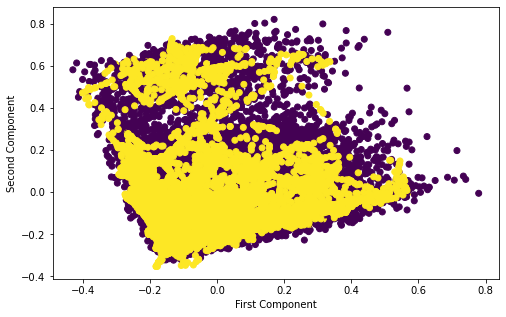

In [88]:
plt.figure(figsize=(8,5))
plt.scatter(x_pca[:,1],x_pca[:,0],c=Data_sm['Likelihood'])
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.show()

In [89]:
Data_PCA=pd.concat([pd.DataFrame(x_pca),Data_sm['Likelihood']],axis=1)
Data_PCA

,0,1,Likelihood
0,0.700608,-0.151415,0
1,0.626116,-0.345063,0
2,0.608065,-0.376997,0
3,0.614805,-0.418707,0
4,0.738465,-0.023622,0
...,...,...,...
23285,0.218849,0.259477,1
23286,0.221914,0.233112,1
23287,-0.190734,-0.095145,1
23288,-0.244747,-0.166864,1


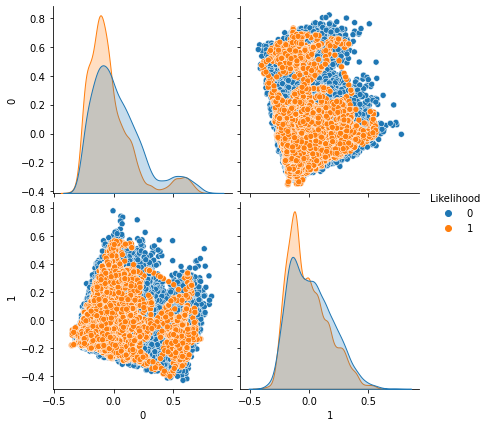

In [90]:
sns.pairplot(Data_PCA,hue='Likelihood',size=3)

In [91]:
X_train_pca,X_test_pca,y_train_pca,y_test_pca=train_test_split(x_pca,y,test_size=0.25,random_state=0)

In [92]:
model_svm=SVC(class_weight='balanced')
model_svm.fit(X_train_pca,y_train_pca)


SVC(class_weight='balanced')

In [93]:
y_pred_pca=model_svm.predict(X_test_pca)
y_pred_pca

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [94]:
print(confusion_matrix(y_test_pca,y_pred_pca))
print('\n')
print(classification_report(y_test_pca,y_pred_pca))

[[1447 1506]
 [ 788 2082]]


              precision    recall  f1-score   support

           0       0.65      0.49      0.56      2953
           1       0.58      0.73      0.64      2870

    accuracy                           0.61      5823
   macro avg       0.61      0.61      0.60      5823
weighted avg       0.61      0.61      0.60      5823



# Conclusion
## From diffferent methods I conclude the Random Forest provde best accuracy and it predicts 96 percent of data correct.